In [1]:
import numpy as np
import wave
from scipy.io import wavfile
from scipy import signal
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input
from tensorflow.keras.layers import Convolution2D, BatchNormalization
from librosa.core import stft
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
import datagen
import wavload
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

Using TensorFlow backend.


In [2]:
num_data = 20000
num_params = 16
samp_length = 67584

X_data = np.zeros(shape=(num_data,samp_length))
print(X_data.shape)

for r in range(0, num_data):
    audio = wavload.readwav('/Users/josephcleveland/FMData/samp' + str(r) + '.wav')[2]
    audio = audio.T[0]
    if(audio.shape != samp_length):
        padded = np.zeros(shape=(samp_length))
        padded[:np.shape(audio)[0]] = audio
        audio = padded
    X_data[r] = audio
    

(20000, 67584)


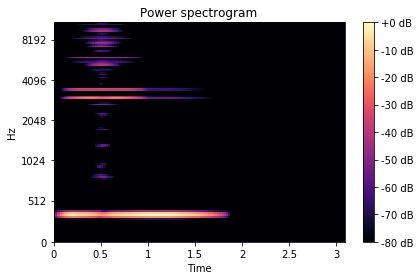

In [134]:
Spectogram = np.abs(librosa.feature.melspectrogram(X_data[2000], sr=44100, n_mels=128))
librosa.display.specshow(librosa.amplitude_to_db(Spectogram,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

In [3]:
Y_data = np.zeros(shape=(num_data))
mat = np.genfromtxt('/Users/josephcleveland/FMData/mat.txt', delimiter=',')
print(mat.shape)
Y_data = mat
Y_train = Y_data
#for i in range(0, 10000):
#    onehot = to_categorical(mat[i], 16)
#    Y_data[i] = onehot.ravel()

(20000, 16)


In [150]:

X_train = np.zeros((num_data, 64, 64))
for i in range(0, num_data):
    X_train[i] = stft(X_data[i],n_fft=1408)[0:64, 0:64]
X_train = np.expand_dims(X_train, axis=3)

Y_train[:, 0] = Y_train[:, 0]/32
print(X_train.shape)
print(Y_train.shape)
print(Y_train[:, 0])

/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


(20000, 64, 64, 1)
(20000, 16)
[0.34375 0.03125 0.4375  ... 0.65625 0.4375  0.03125]


In [110]:
print(X_train[0])

[[[-2.00806671e+02]
  [-3.55063995e+02]
  [-9.79410477e+01]
  ...
  [ 5.87722314e+03]
  [ 4.23114453e+03]
  [ 2.43139038e+02]]

 [[-2.08325825e+01]
  [ 2.56033630e+02]
  [ 1.03052208e+02]
  ...
  [-4.28779736e+03]
  [-7.13751038e+02]
  [-7.48981079e+02]]

 [[ 2.83232178e+02]
  [-3.81334137e+02]
  [ 2.98087280e+02]
  ...
  [ 1.51718789e+04]
  [ 8.61241016e+03]
  [-4.00370020e+03]]

 ...

 [[ 2.49706936e+01]
  [-4.41311836e+00]
  [-1.06559253e+03]
  ...
  [ 2.10568335e+03]
  [ 6.91529443e+03]
  [ 2.45063187e+02]]

 [[-2.88655758e+00]
  [ 8.24961975e+02]
  [-3.10945508e+03]
  ...
  [ 1.55984951e+04]
  [-3.63758203e+04]
  [-1.88124258e+04]]

 [[-3.57541580e+01]
  [ 5.74109253e+02]
  [ 7.37528906e+03]
  ...
  [-3.35154023e+04]
  [ 8.34520234e+04]
  [ 7.23578438e+04]]]


In [40]:
X_train = np.zeros((num_data, 4096))
for i in range(0, num_data):
    X_train[i] = stft(X_data[i],n_fft=1408)[0:64, 0:64].ravel()

regr = RandomForestRegressor(max_depth=2, random_state=0,
                              n_estimators=100)
regr.fit(X_train, Y_train)


/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [104]:
o = regr.predict(X_train)

dist_total = 0
for i in range(0, num_data):
    dist_total += np.absolute(o[i] - mat[i, 0])
average_dist = dist_total / num_data
print(average_dist)

ValueError: Found array with dim 4. Estimator expected <= 2.

In [151]:
inputs = Input(shape=(64,64,1))

# a layer instance is callable on a tensor, and returns a tensor
x = BatchNormalization()(inputs)
x = Convolution2D(32, kernel_size=(4, 5), strides=(3, 4), padding="same", activation='relu')(x)
x = Convolution2D(98, kernel_size=(4, 6), strides=(3, 5), padding="same", activation='relu')(x)
x = Convolution2D(128, kernel_size=(4, 6), strides=(3, 5), padding="same", activation='relu')(x)
#x = Convolution2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu')(x)
#x = Convolution2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu')(x)
#x = Convolution2D(128, kernel_size=(3, 3), strides=(2, 1), padding="same", activation='relu')(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(16)(x)
# This creates a model that includes
# the Input layer and three Dense layers
adam = optimizers.Adam(lr=0.00001)
model = Model(inputs=inputs, outputs=x)
model.compile(adam,
              loss='mean_squared_error',
              metrics=['accuracy'])

In [152]:
model.fit(X_train, Y_train, 
          batch_size=16, epochs=50, verbose=1, validation_split=0.1)

Train on 18000 samples, validate on 2000 samples
Epoch 1/50
18000/18000 [==============================] - 20s 1ms/sample - loss: 0.1074 - accuracy: 0.1297 - val_loss: 0.0729 - val_accuracy: 0.1750
Epoch 2/50
18000/18000 [==============================] - 16s 883us/sample - loss: 0.0682 - accuracy: 0.1702 - val_loss: 0.0660 - val_accuracy: 0.1995
Epoch 3/50
18000/18000 [==============================] - 16s 916us/sample - loss: 0.0647 - accuracy: 0.1798 - val_loss: 0.0645 - val_accuracy: 0.2075
Epoch 4/50
18000/18000 [==============================] - 15s 841us/sample - loss: 0.0631 - accuracy: 0.1861 - val_loss: 0.0635 - val_accuracy: 0.2115
Epoch 5/50
18000/18000 [==============================] - 15s 850us/sample - loss: 0.0621 - accuracy: 0.1929 - val_loss: 0.0626 - val_accuracy: 0.2020
Epoch 6/50
18000/18000 [==============================] - 15s 848us/sample - loss: 0.0612 - accuracy: 0.1943 - val_loss: 0.0619 - val_accuracy: 0.2155
Epoch 7/50
18000/18000 [=======================

In [153]:
o = model.predict(X_train)

/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


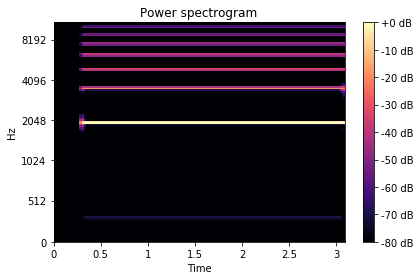

In [145]:
audio = wavload.readwav('/Users/josephcleveland/Desktop/Screech.wav')[2]
audio = audio.T[0]

X_audio = audio[0:67584].astype(float)
X_piano = np.zeros((1, 64, 64))
X_piano[0] = stft(X_audio,n_fft=1408)[0:64, 0:64]
X_piano = np.expand_dims(X_piano, axis=3)

Spectogram = np.abs(librosa.feature.melspectrogram(X_audio, sr=44100, n_mels=128))
librosa.display.specshow(librosa.amplitude_to_db(Spectogram,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

o = model.predict(X_piano)

In [154]:
average_dist = np.zeros(16)

for p in range(0, 16):
    dist_total = 0
    for i in range(0, num_data):
        dist_total += np.absolute(o[i, p] - Y_train[i, p])
    average_dist[p] = dist_total / num_data
    
print(average_dist)
print("average: ", np.average(average_dist))

[0.10731506 0.12534804 0.1477895  0.1636379  0.12965618 0.21153298
 0.18053149 0.21031341 0.16461572 0.16638492 0.19702521 0.18121467
 0.22306882 0.21000455 0.23129068 0.13962585]
average:  0.17433468650448455


In [125]:

vals = np.random.uniform(0, 1, 1000)
print(np.mean(vals))
print(Y_train[5])
print(o[5])
print(Y_train[5, 0] * 32 * 32)

0.48983281379878524
[0.02246094 0.098      0.51       0.203      0.602      0.821
 0.667      0.374      0.211      0.353      0.962      0.052
 0.785      0.852      0.649      0.779     ]
[0.05464076 0.10908591 0.54581136 0.47049633 0.7130788  0.5762943
 0.574171   0.5971361  0.3758217  0.43692404 1.0267307  0.5431005
 0.6158145  0.6210662  0.574561   0.56807566]
23.0


In [129]:
o[:, 0] = o[:, 0] * 32 * 32

np.savetxt("/Users/josephcleveland/FMData/predictions.csv", o, delimiter=",")

In [279]:
# Save the weights
model.save_weights('Regression1_weights.h5')

# Save the model architecture
with open('Regression1_architecture.json', 'w') as f:
    f.write(model.to_json())